In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

## Preliminary Analysis

In [2]:
loan_df = pd.read_csv('./loan_timing.csv')
display(loan_df.head())
display(loan_df.describe())

,days since origination,days from origination to chargeoff
0,109,NaN
1,679,NaN
2,723,NaN
3,509,NaN
4,254,NaN


,days since origination,days from origination to chargeoff
count,50000.000000,3305.000000
mean,365.844760,214.852345
std,210.965114,165.233874
min,0.000000,0.000000
25%,183.000000,76.000000
50%,366.000000,180.000000
75%,549.000000,323.000000
max,730.000000,725.000000


In [3]:
# 3 years
days_to_repaid = 3 * 365
print("Data Vaildation : charge off after 3 years count", 
      len(loan_df[loan_df['days from origination to chargeoff'] > days_to_repaid]))
print("Data Vaildation : loans age greater than 3 years count", 
      len(loan_df[loan_df['days since origination'] > days_to_repaid]))

Data Vaildation : charge off after 3 years count 0
Data Vaildation : loans age greater than 3 years count 0


## charged off loans

In [4]:
charged_off_df = loan_df[~loan_df['days from origination to chargeoff'].isna()]
display(charged_off_df.head())

,days since origination,days from origination to chargeoff
14,327,78.0
15,400,390.0
16,721,362.0
26,410,48.0
61,649,412.0


## paid loans

In [5]:
paid_df = loan_df[loan_df['days from origination to chargeoff'].isna()]
display(paid_df.head())

,days since origination,days from origination to chargeoff
0,109,NaN
1,679,NaN
2,723,NaN
3,509,NaN
4,254,NaN


<IPython.core.display.Javascript object>


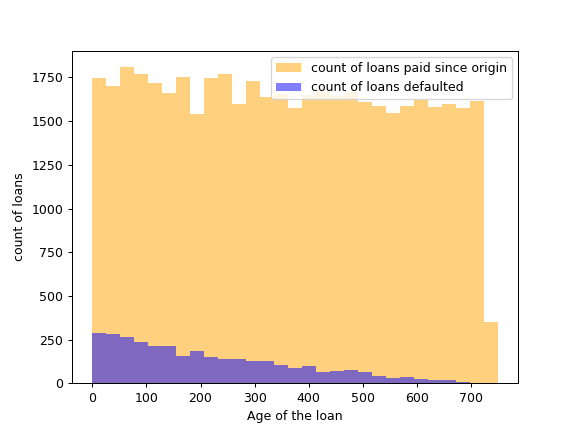

In [6]:
% matplotlib notebook
# charged_off_df.hist('days from origination to chargeoff', bins=30)
# paid_df.hist('days since origin', bin=30)
bins = np.linspace(0, 750, 30)
# bins=30
plt.hist(paid_df['days since origination'], bins, alpha=0.5, 
         label='count of loans paid since origin', color='orange')
plt.hist(charged_off_df['days from origination to chargeoff'], bins, alpha=0.5, 
         label='count of loans defaulted', color='blue')
plt.legend(loc='upper right')
plt.ylabel('count of loans')
plt.xlabel('Age of the loan')
plt.show()

According to the above graph their is an gradual decrease in the customers who default as time from the origin increases. In other words we can see a lot of defaulters at the early ages after the loan is approved.

<IPython.core.display.Javascript object>


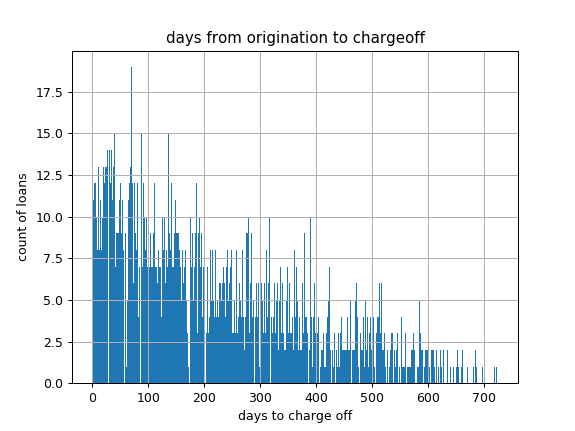

In [7]:
charged_off_df.hist('days from origination to chargeoff', bins=750)
plt.legend(loc='upper right')
plt.ylabel('count of loans')
plt.xlabel('days to charge off')
plt.show()

<IPython.core.display.Javascript object>


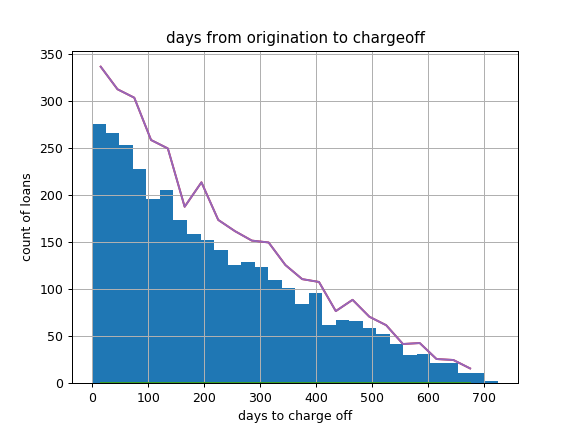

In [32]:
charged_off_df.hist('days from origination to chargeoff', bins=30)
plt.legend(loc='upper right')
plt.ylabel('count of loans')
plt.xlabel('days to charge off')
plt.show()

The decrease seems to be exponential with some seasonality. But I am going to ignore the seasonality in the model

# Model

In [13]:
days_to_charged_off = charged_off_df['days from origination to chargeoff'].values
days_since_origin_not_charged_off = paid_df['days since origination'].values

## Convert the data into list of lists
using 30 days bin --> to catch montly seasonality if any

Time 
 [15.0, 45.0, 75.0, 105.0, 135.0, 165.0, 195.0, 225.0, 255.0, 285.0, 315.0, 345.0, 375.0, 405.0, 435.0, 465.0, 495.0, 525.0, 555.0, 585.0, 615.0, 645.0, 675.0, 705.0, 735.0, 765.0, 795.0, 825.0, 855.0, 885.0, 915.0, 945.0, 975.0, 1005.0, 1035.0, 1065.0]
Charged off count 
 [337, 313, 304, 259, 250, 188, 214, 174, 162, 152, 150, 126, 111, 108, 77, 89, 71, 62, 42, 43, 26, 25, 16, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Not charged off count 
 [1981, 2037, 2057, 2032, 1919, 2014, 1859, 2012, 1940, 1934, 1927, 1921, 1914, 1874, 1957, 1909, 1861, 1869, 1820, 1875, 1857, 1789, 1826, 1851, 660, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<IPython.core.display.Javascript object>


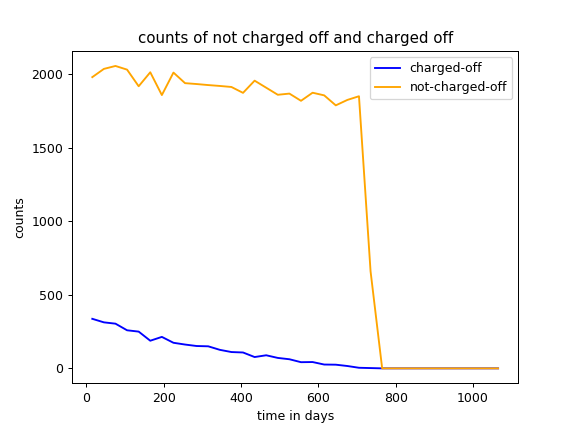

In [60]:
def data_to_buckets(data, window):
    x, y = [], []
    lower_limit = 0
    for upper_limit in range(window, 1095, window):
        mid = (lower_limit + upper_limit)/2
        x.append(mid)
        y.append(len([dp for dp in data if lower_limit <= dp < upper_limit]))
        lower_limit = upper_limit
    return x, y

time, charged_off_count = data_to_buckets(days_to_charged_off.tolist(), 30)
time, not_charged_off_count = data_to_buckets(days_since_origin_not_charged_off.tolist(), 30)
print("Time \n", time)
print("Charged off count \n", charged_off_count)
print("Not charged off count \n", not_charged_off_count)


% matplotlib notebook
plt.title("counts of not charged off and charged off")
plt.plot(time, charged_off_count, color='blue', label='charged-off')
plt.plot(time, not_charged_off_count, color='orange', label='not-charged-off')
plt.ylabel('counts')
plt.xlabel('time in days')
plt.legend()
plt.show()

Zeros are due not data 

The probability almost became zero by the end of 2 years. 

From here on we can handle problem in couple of ways. 

    . Fit an exponentially decreasing function to the curve and extend it until 3 years
    
    . Assume the probability after 700 days as 0.001 and continue it until the end of 3 years.
    
For the sake of simplicity I am sticking to the 2nd approach.

## Calculate the probablity of getting charged-off in each bin.

Note: At very bin we have enough data to get a good probability estimate.

<IPython.core.display.Javascript object>


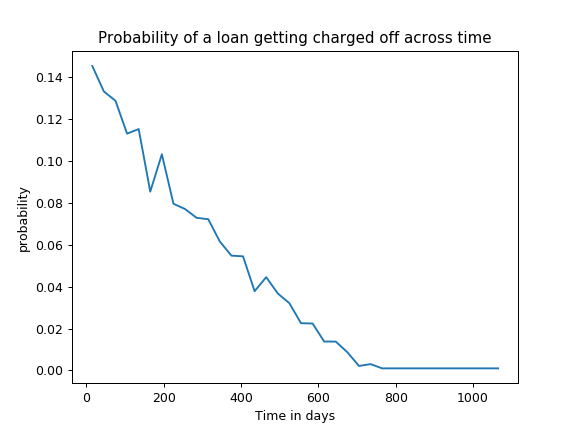

In [65]:
probability_of_charge_off = []
for x,y in zip(charged_off_count, not_charged_off_count):
    if x != 0 and y != 0:
        probability_of_charge_off.append(x/(x+y))
    else:
        probability_of_charge_off.append(0.001)
% matplotlib notebook
plt.title("Probability of a loan getting charged off across time")
plt.xlabel('Time in days')
plt.ylabel("probability")
plt.plot(time, probability_of_charge_off)
plt.show()

## Predict count of loans that will be charged off

move the loans to the next bin if not charged off and repeat this until 3 years

<IPython.core.display.Javascript object>


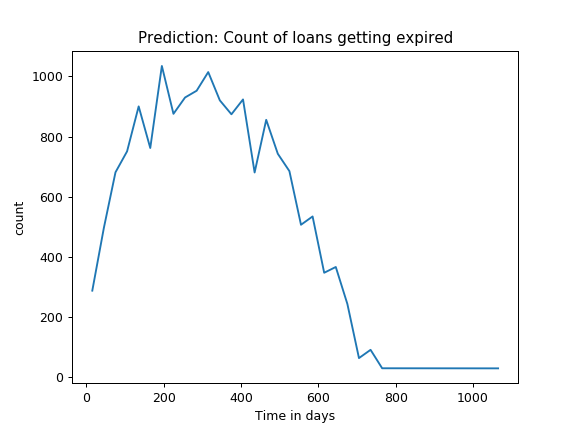

In [66]:
predicted_charged_off_count = []
move_forward_count = 0

for not_charged_off_bin_count, charge_off_prob in zip(not_charged_off_count, probability_of_charge_off):
    total_in_bin = not_charged_off_bin_count + move_forward_count
    charged_in_bin = total_in_bin * charge_off_prob
    move_forward_count = total_in_bin - charged_in_bin
    predicted_charged_off_count.append(charged_in_bin)

% matplotlib notebook
plt.plot(time, predicted_charged_off_count)
plt.title("Prediction: Count of loans getting expired")
plt.ylabel("count")
plt.xlabel("Time in days")
plt.show()

In [74]:
print("Predicted charge_off count at the end of 3 years of age for every loan", sum(predicted_charged_off_count))
print("Predicted charge_off count at the end of 2 years of age for every loan", sum(predicted_charged_off_count[:25]))
print("Predicted charge_off count at the end of 2 years of age for every loan", sum(predicted_charged_off_count[:13]))

Predicted charge_off count at the end of 3 years of age for every loan 16850.273178727282
Predicted charge_off count at the end of 2 years of age for every loan 16520.00286616677
Predicted charge_off count at the end of 2 years of age for every loan 10478.398387160943


In [69]:
len(paid_df)

46695

## Out off the total 46,695 loans that are not charged off as of now about 16,850 might get charged off by the end 3 years of their age (age of each loan)

Approximately 37%